## 导入依赖

In [1]:
import os
import copy
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt
# 阿凯机器人工具箱
from kyle_robot_toolbox.yolov8 import YoloV8Segment
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.open3d import *
from kyle_robot_toolbox.transform import *
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


pybullet build time: May 20 2022 19:44:17


## 载入模型

In [2]:
# 模型路径
model_path = os.path.join(os.path.abspath("."), "weights", "color_block_yolov8seg.pt")
# 载入实例分割模型(使用绝对路径)
model = YoloV8Segment(model_path)

## 创建相机对象

In [3]:
# 创建相机对象
camera = Gemini335()

[I20230507 02:18:10.448834 533842 Context.cpp:13] Context creating!
[I20230507 02:18:10.449014 533842 Context.cpp:78] filter version[major.minor.maintenance.build]: 1.1.4.0
[I20230507 02:18:10.449038 533842 DeviceManager.cpp:54] DeviceManager init ...
[I20230507 02:18:10.449416 533842 LinuxPal.cpp:21] createObPal: create LinuxPal!
[I20230507 02:18:10.527171 533842 EnumeratorLibusb.cpp:325] queryDevicesInfo done!
[I20230507 02:18:10.527626 533842 DeviceManager.cpp:373] Current usb device port list::
[I20230507 02:18:10.527640 533842 DeviceManager.cpp:375]         - 2-5.4.1-6.0 | Orbbec Gemini 2 Depth Camera
[I20230507 02:18:10.527648 533842 DeviceManager.cpp:375]         - 2-5.4.1-6.2 | Orbbec Gemini 2 IR Camera
[I20230507 02:18:10.527657 533842 DeviceManager.cpp:375]         - 2-5.4.1-6.4 | Orbbec Gemini 2 RGB Camera
[I20230507 02:18:10.527663 533842 DeviceManager.cpp:375]         - 2-5.4.1-6.6 | Orbbec Gemini Data Channel
[I20230507 02:18:10.527669 533842 DeviceManager.cpp:375]       

## 采集图像

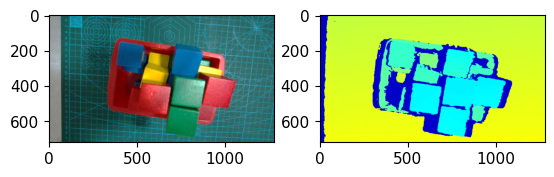

In [4]:
color_img, depth_img = camera.read()
depth_canvas = camera.depth_img2canvas(depth_img)
plt.subplot(1, 2, 1)
plt.imshow(color_img[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(depth_canvas[:, :, ::-1])

In [5]:
cv2.imwrite("color_img.png", color_img)
cv2.imwrite("depth_canvas.png", depth_canvas)

True

In [6]:
# 原始点云
pcd_scene = camera.get_pcd(color_img, depth_img)
draw_geometry([pcd_scene])

## 模型预测


0: 640x1088 8 color_blocks, 33.2ms
Speed: 6.1ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 1088, 1088)


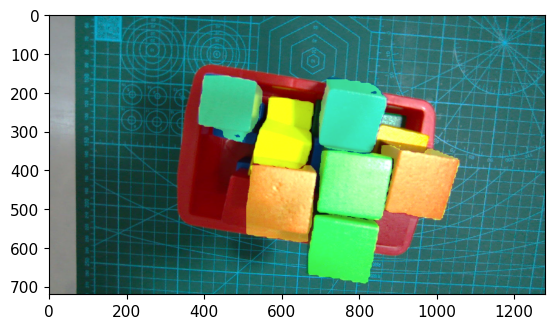

In [7]:
result = model.segment(color_img)
canvas, class_id_list, obj_mask_list, xyxy_list, conf_list = result 
plt.imshow(canvas[:, :, ::-1])

In [8]:
cv2.imwrite("canvas.png", canvas)

True

物体类别ID列表: [0, 0, 0, 0, 0, 0, 0, 0]
ROI区域: [665, 511, 848, 690]
置信度: 0.967


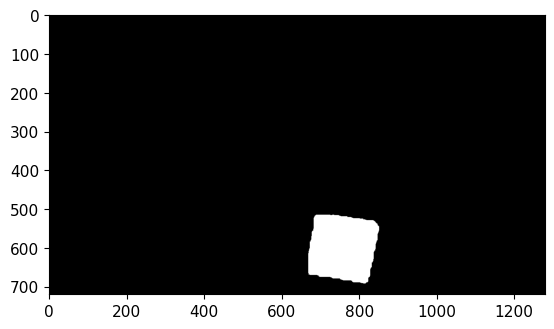

In [9]:
obj_idx = 0
print(f"物体类别ID列表: {class_id_list}")
print(f"ROI区域: {xyxy_list[obj_idx]}")
print(f"置信度: {conf_list[obj_idx]:.3f}")
# 显示物体的Mask
mask = obj_mask_list[obj_idx]
plt.imshow(mask, cmap="gray")

## 获取实例点云

In [10]:
def get_obj_pcd_list(color_img, depth_img, obj_mask_list):
    '''获取物体PCD列表'''
    obj_pcd_list = []
    for mask in obj_mask_list:
        obj_pcd = camera.get_pcd(color_img, depth_img, mask=mask)
        obj_pcd.paint_uniform_color([np.random.rand() for i in range(3)])
        obj_pcd_list.append(obj_pcd)
    return obj_pcd_list

In [ ]:
obj_pcd_list = get_obj_pcd_list(color_img, depth_img, obj_mask_list)
# 展示其中一个实例点云
draw_geometry(obj_pcd_list)

## 移除噪声

In [ ]:
# obj_pcd = obj_pcd_list[0]
# # 移除离群点
# cl, ind = obj_pcd.remove_statistical_outlier(nb_neighbors=20,
#                                         std_ratio=0.1)
# # 展示离群点
# display_inlier_outlier(obj_pcd, ind)
# # 筛选点云
# obj_pcd_filter = obj_pcd.select_by_index(ind)
# draw_geometry([obj_pcd_filter], window_name="移除离群点后的上表面点云")

In [ ]:
def remove_outlier(obj_pcd_list):
    '''移除离群点'''
    obj_pcd_list_filter = []
    for obj_pcd in obj_pcd_list:
        # 移除离群点
        cl, ind = obj_pcd.remove_statistical_outlier(nb_neighbors=10,
                                                std_ratio=0.2)
        # 展示离群点
        # display_inlier_outlier(obj_pcd, ind)
        # 筛选点云
        obj_pcd_filter = obj_pcd.select_by_index(ind)
        obj_pcd_list_filter.append(obj_pcd_filter)
    return obj_pcd_list_filter

In [ ]:
# 移除离群点
# obj_pcd_list_filter = remove_outlier(obj_pcd_list)
# 注意事项: 移除离群点这个操作是非必须的
obj_pcd_list_filter = obj_pcd_list

可视化

In [ ]:
# 展示所有实例的点云
pcd_scene_copy = copy.deepcopy(pcd_scene)
pcd_scene_copy.transform(Transform.dzmat(+0.001)) # 轻轻
draw_geometry([pcd_scene_copy] + obj_pcd_list_filter)

## 获取中心点与法向量估计
只保留最大平面

In [ ]:
def get_center_point_and_norm(obj_pcd, is_debug=False):
    '''获取点云中心点跟法向量'''
    # 距离阈值 单位m
    # 距离平面多少的点被认为是在这个平面上的点
    distance_threshold = 0.005
    # 平面拟合
    plane_model, inliers = obj_pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=3,
                                             num_iterations=100)
    # 打印拟合平面的表达式
    [a, b, c, d] = plane_model
    if is_debug:
        print(f"盒子上表面的表达式: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
    # 获取上表面的点云
    obj_top_pcd = obj_pcd.select_by_index(inliers)
    obj_top_pcd.paint_uniform_color([1.0, 0, 0])
    # 点云的中心点
    center_point = obj_top_pcd.get_center()
    # 获取平面法向量
    center_normal_vector = get_panel_normal_vector(a, b, c, d)
    # 法向量重定向
    center_normal_vector = normal_vector_redirect(center_normal_vector, center_point)
    if is_debug:
        print(f"平面法向量: \n{center_normal_vector}")
    return center_point, center_normal_vector



生成旋转矩阵+可视化

In [ ]:
def get_norm_arrow_geometry(center_point, center_normal_vector, is_debug=False):
    '''获取法向量可视化模型'''
    # 可视化，在质心位置绘制小球
    mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.003)
    mesh_sphere.compute_vertex_normals()
    # 小球平移
    mesh_sphere.translate(center_point.reshape(-1), relative=False)
    # 给小球上色为红色
    mesh_sphere.paint_uniform_color([1.0, 1.0, 1.0])
    
    # 计算向量之间的夹角
    z0 = np.float64([0, 0, 1]).reshape((3, 1))
    cos_theta = z0.T.dot(center_normal_vector)
    theta = np.arccos(cos_theta)
    # 向量叉乘得到旋转轴
    rot_vect = np.cross(z0.reshape(-1), center_normal_vector.reshape(-1))
    rot_vect /= np.linalg.norm(rot_vect) # 归一化
    if is_debug:
        print(f"旋转向量: {rot_vect}")
    # 构造旋转矩阵
    rot_mat = cv2.Rodrigues(rot_vect*theta)[0]
    if is_debug:
        print(f"旋转矩阵:\n  {rot_mat}")
    # 绘制箭头
    mesh_arrow = o3d.geometry.TriangleMesh.create_arrow(\
                        cylinder_radius=0.002, cone_radius=0.004,\
                        cylinder_height=0.05,  cone_height=0.01, \
                        resolution=20, cylinder_split=4, cone_split=1)

    mesh_arrow.paint_uniform_color([0.0, 0.0, 1.0])
    mesh_arrow.rotate(rot_mat, center=(0, 0, 0))
    mesh_arrow.translate(center_point.reshape(-1), relative=True)
    return mesh_sphere, mesh_arrow

可视化单个

In [ ]:
obj_pcd_raw = obj_pcd_list_filter[1]
# 获取中心点跟法向量
center_point, center_normal_vector = get_center_point_and_norm(obj_pcd_raw)
# 生成箭头
mesh_sphere, mesh_arrow = get_norm_arrow_geometry(center_point, center_normal_vector)
# 绘制可视化模型
draw_geometry([pcd_scene, mesh_sphere, mesh_arrow], bk_color=[1, 1, 1], point_show_normal=False, \
              window_name="绘制单个物块上表面的法向量")

In [ ]:
geometry_list = [pcd_scene]
center_point_list = []
center_normal_vector_list = []
for obj_pcd_raw in obj_pcd_list_filter:
    # 获取中心点跟法向量
    center_point, center_normal_vector = get_center_point_and_norm(obj_pcd_raw)
    # 添加到列表
    center_point_list.append(center_point)
    center_normal_vector_list.append(center_normal_vector)
    # 生成箭头
    mesh_sphere, mesh_arrow = get_norm_arrow_geometry(center_point, center_normal_vector)
    geometry_list.append(mesh_sphere)
    geometry_list.append(mesh_arrow)
    
# 绘制可视化模型
draw_geometry(geometry_list, bk_color=[1, 1, 1], point_show_normal=False, \
              window_name="绘制所有物块上表面的法向量")